In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)
size = 5
pre_smoothing = False
conv = True
sigma = 0.1


import logging
tf.get_logger().setLevel(logging.ERROR)

2023-03-27 20:19:32.939713: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 20:19:35.500057: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-03-27 20:19:35.500123: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-27 20:19:41.353970: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerr

# Data augmentation

In [2]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=30,var1_u=60,CROP1=CROP,BATCH_SIZE=5)

2023-03-27 20:19:53.758836: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-03-27 20:19:53.774157: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-27 20:19:53.774304: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (joel-Latitude-5410): /proc/driver/nvidia/version does not exist
2023-03-27 20:19:53.828653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropria

In [3]:
xs, ys = next(gen_batch_val.as_numpy_iterator())

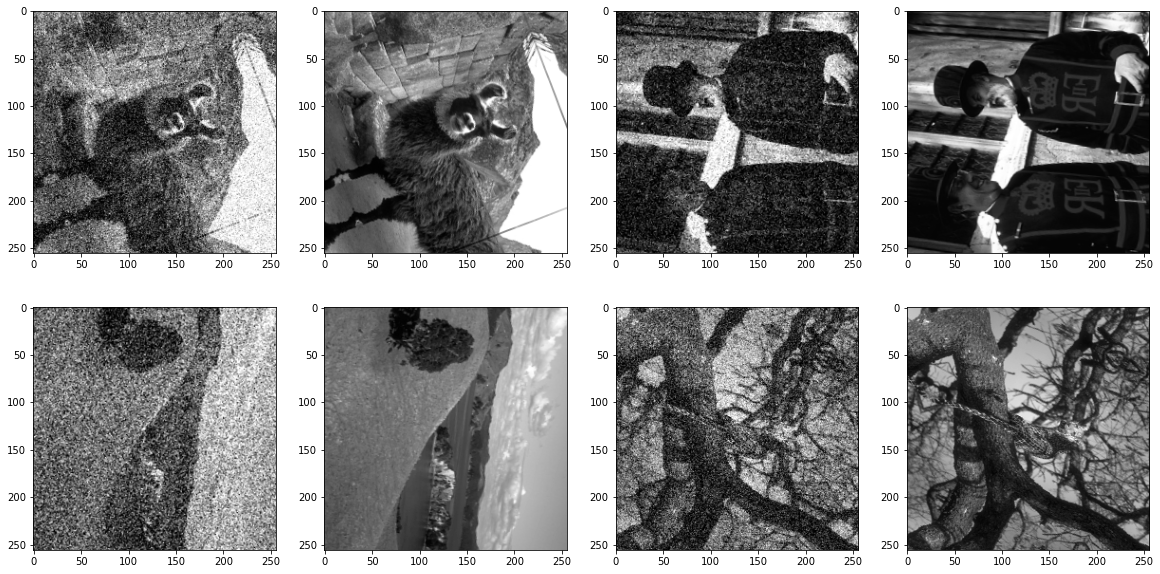

In [4]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(xs[_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        #axs[i,2*j].set_title(str(np.mean(xs[_])))
        
plt.show()

# Searching optimal values

In [81]:
search_psnr,search_ssim = [],[]
search_psnr0,search_ssim0 = [],[]
for noise in [10,20,50]:
    print(noise)
    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=noise,var1_u=noise,CROP1=CROP,BATCH_SIZE=50)
    xs, ys = next(gen_batch_train.as_numpy_iterator())
    
    search_psnr.append([])
    search_ssim.append([])
    search_psnr0.append([])
    search_ssim0.append([])
    for T in tqdm(np.arange(1,100,2)[::-1]):
        search_psnr[-1].append([])
        search_ssim[-1].append([])
        search_psnr0[-1].append([])
        search_ssim0[-1].append([])
        for K in np.linspace(0.1,1,100):
            
            pm = np.array([anisodiff(im,niter = T,lambd=K) for im in xs])
            pm = np.asarray(pm,dtype='float32')
            
            psnr = tf.image.psnr(pm,ys,1).numpy() 
            ssim = tf.image.ssim(pm,ys,1).numpy()
            
            psnr_or = tf.image.psnr(xs,ys,1).numpy() 
            ssim_or = tf.image.ssim(xs,ys,1).numpy() 
            
            search_psnr[-1][-1].append(np.mean(psnr))
            search_ssim[-1][-1].append(np.mean(ssim))
            
            search_psnr0[-1][-1].append(np.mean(psnr_or))
            search_ssim0[-1][-1].append(np.mean(ssim_or))



10


100%|████████████████████████████████████████| 50/50 [1:24:27<00:00, 101.35s/it]


20


100%|████████████████████████████████████████| 50/50 [1:24:38<00:00, 101.57s/it]


50


100%|████████████████████████████████████████| 50/50 [1:24:26<00:00, 101.33s/it]


In [35]:
#search_psnr = np.array(search_psnr)
#search_psnr0 = np.array(search_psnr0)
#search_ssim = np.array(search_ssim)
#search_ssim0 = np.array(search_ssim0)

#np.save('./psnr_optimal.npy',search_psnr)
#np.save('./psnr_optimal0.npy',search_psnr0)
#np.save('./ssim_optimal.npy',search_ssim)
#np.save('./ssim_optimal0.npy',search_ssim0)

search_psnr = np.load('./psnr_optimal.npy')
search_psnr0 = np.load('./psnr_optimal0.npy')
search_ssim = np.load('./ssim_optimal.npy')
search_ssim0 = np.load('./ssim_optimal0.npy')

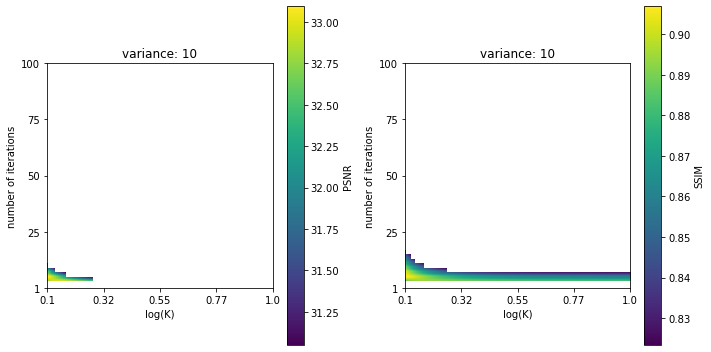

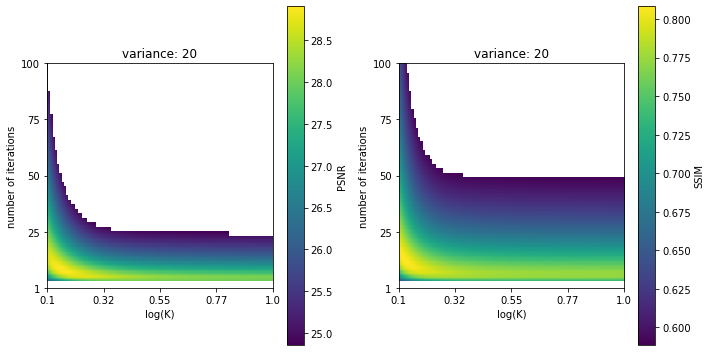

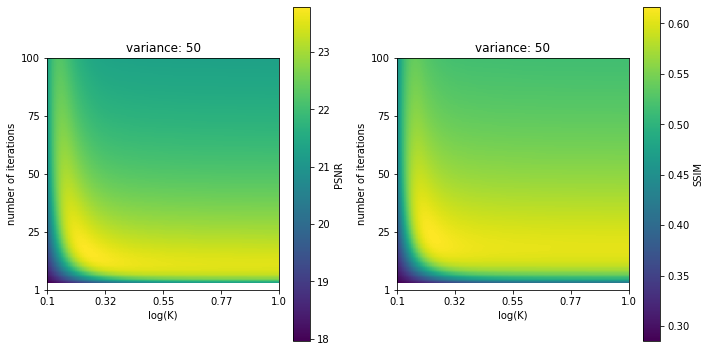

In [40]:
var = [10,20,50]

for i in range(len(var)):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.title(f'variance: {var[i]}')
    plt.ylabel('number of iterations')
    plt.xlabel('log(K)')
    labels = np.linspace(0.1,1,5)
    labels = np.asarray(100*labels,dtype='int')/100
    plt.xticks(np.linspace(0,10,5),labels)
    labels = np.linspace(1,100,5)
    labels = np.asarray(labels,dtype='int')
    plt.yticks(np.linspace(0,10,5),labels)
    #im = np.array(search_psnr[i])/np.array(search_psnr0[i])>1
    #im = np.multiply(im,search_psnr[i])
    im = np.array(search_psnr[i])
    im[np.array(search_psnr[i])/np.array(search_psnr0[i])<=1] = np.nan
    plt.imshow(im,extent=[0,10,0,10],interpolation=None)
    plt.colorbar(label='PSNR')
    plt.subplot(122)
    plt.title(f'variance: {var[i]}')
    plt.ylabel('number of iterations')
    plt.xlabel('log(K)')
    labels = np.linspace(0.1,1,5)
    labels = np.asarray(100*labels,dtype='int')/100
    plt.xticks(np.linspace(0,10,5),labels)
    labels = np.linspace(1,100,5)
    labels = np.asarray(labels,dtype='int')
    plt.yticks(np.linspace(0,10,5),labels)
    #im = np.array(search_ssim[i])/np.array(search_ssim0[i])>1
    #im = np.multiply(im,search_ssim[i])
    im = np.array(search_ssim[i])
    im[np.array(search_ssim[i])/np.array(search_ssim0[i])<=1] = np.nan
    plt.imshow(im,extent=[0,10,0,10],interpolation=None)
    plt.colorbar(label='SSIM')
    plt.tight_layout()
    plt.show()

In [10]:
search_psnr,search_ssim = [],[]
search_psnr0,search_ssim0 = [],[]
for noise in np.arange(10,55,5):
    print(noise)
    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=noise,var1_u=noise,CROP1=CROP,BATCH_SIZE=50)
    xs, ys = next(gen_batch_train.as_numpy_iterator())
    
    search_psnr.append([])
    search_ssim.append([])
    search_psnr0.append([])
    search_ssim0.append([])
    T = 10
        
    for K in tqdm(np.linspace(0.1,1,100)):

        pm = np.array([anisodiff(im,niter = T,lambd=K) for im in xs])
        pm = np.asarray(pm,dtype='float32')

        psnr = tf.image.psnr(pm,ys,1).numpy() 
        ssim = tf.image.ssim(pm,ys,1).numpy()

        psnr_or = tf.image.psnr(xs,ys,1).numpy() 
        ssim_or = tf.image.ssim(xs,ys,1).numpy() 

        search_psnr[-1].append(np.mean(psnr))
        search_ssim[-1].append(np.mean(ssim))

        search_psnr0[-1].append(np.mean(psnr_or))
        search_ssim0[-1].append(np.mean(ssim_or))



10


100%|█████████████████████████████████████████| 100/100 [11:06<00:00,  6.66s/it]


15


100%|█████████████████████████████████████████| 100/100 [11:27<00:00,  6.88s/it]


20


100%|█████████████████████████████████████████| 100/100 [10:45<00:00,  6.46s/it]


25


100%|█████████████████████████████████████████| 100/100 [11:32<00:00,  6.92s/it]


30


100%|█████████████████████████████████████████| 100/100 [10:54<00:00,  6.55s/it]


35


100%|█████████████████████████████████████████| 100/100 [11:01<00:00,  6.62s/it]


40


100%|█████████████████████████████████████████| 100/100 [11:30<00:00,  6.91s/it]


45


100%|█████████████████████████████████████████| 100/100 [12:00<00:00,  7.20s/it]


50


100%|█████████████████████████████████████████| 100/100 [11:45<00:00,  7.05s/it]


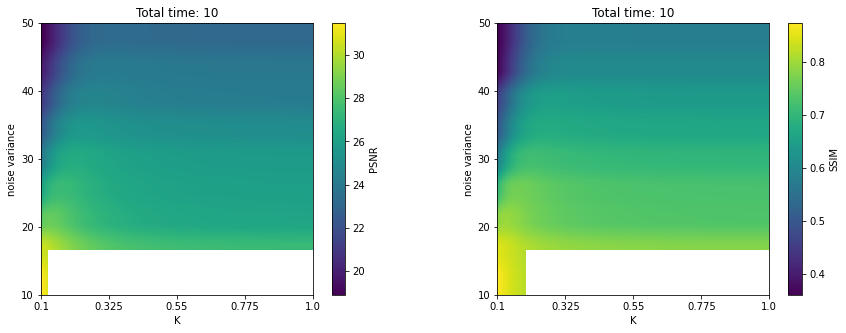

In [31]:
plt.figure(figsize=(15,5))
plt.subplot(121)
#im = np.array(search_psnr)/np.array(search_psnr0)>1
#im = np.multiply(im,search_psnr)
im = np.array(search_psnr)
im[np.array(search_psnr)/np.array(search_psnr0)<=1] = np.nan
plt.imshow(im[::-1],extent=[0,10,0,10],interpolation=None)
plt.colorbar(label="PSNR")
plt.xlabel("K")
plt.ylabel("noise variance")
plt.title("Total time: 10")
plt.xticks(np.linspace(0,10,5),np.linspace(0.1,1,5))

noises = np.arange(10,55,5)
plt.yticks(np.linspace(0,10,5),noises[np.asarray(np.linspace(0,len(noises)-1,5),dtype="int")])

plt.subplot(122)
#im = np.array(search_ssim)/np.array(search_ssim0)>1
#im = np.multiply(im,search_ssim)
im = np.array(search_ssim)
im[np.array(search_ssim)/np.array(search_ssim0)<=1] = np.nan
plt.imshow(im[::-1],extent=[0,10,0,10],interpolation=None)
plt.colorbar(label="SSIM")
plt.xlabel("K")
plt.ylabel("noise variance")
plt.title("Total time: 10")
plt.xticks(np.linspace(0,10,5),np.linspace(0.1,1,5))

noises = np.arange(10,55,5)
plt.yticks(np.linspace(0,10,5),noises[np.asarray(np.linspace(0,len(noises)-1,5),dtype="int")])
plt.show()

In [32]:
search_psnr = np.array(search_psnr)
search_psnr0 = np.array(search_psnr0)
search_ssim = np.array(search_ssim)
search_ssim0 = np.array(search_ssim0)

#np.save('./psnr_optimal_final_time.npy',search_psnr)
#np.save('./psnr_optima_final_timel0.npy',search_psnr0)
#np.save('./ssim_optimal_final_time.npy',search_ssim)
#np.save('./ssim_optimal_final_time0.npy',search_ssim0)